# Generating Data with autocorrelation and temporal lag

## Imports

In [78]:
from scipy.interpolate import interp1d
from scipy.special import sinc
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mpl
import matplotlib.patches as patches
%matplotlib inline

## Make sine

The data is based on a sine wave with arbitrary parameters

In [9]:
# parameters
f = 0.25
tp = 100
t = np.arange(-10, 10, 1/tp)
s = 1*np.sin(2 * np.pi * f * t + 0)

### Plot

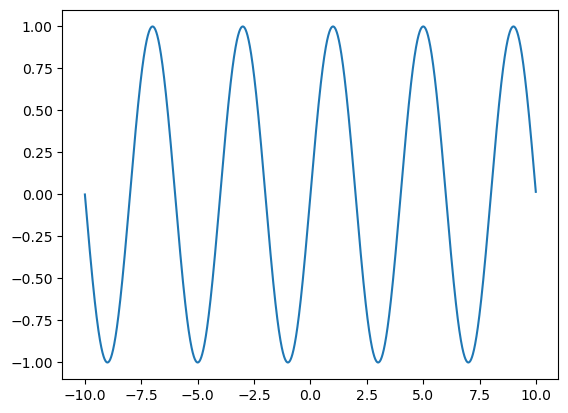

In [3]:
plt.plot(t, s)

## Create data

The data is a voxel X time point matrix, $X$.

### Make empty matrix

In [10]:
X = np.zeros((10, np.size(s)))

### Append generated sine wave

In [11]:
for i in range(len(X)):
    X[i, :] = s

### Plot

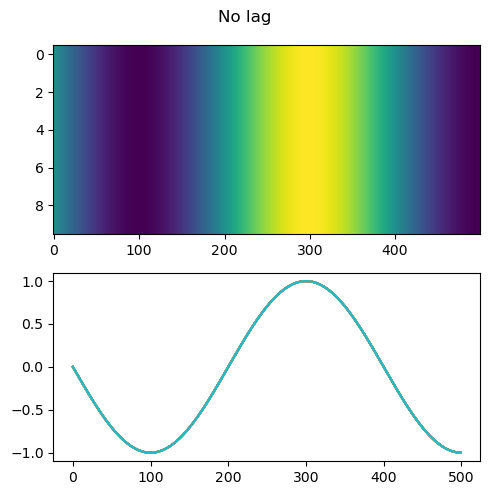

In [23]:
fig , ax = plt.subplots(ncols=1, nrows=2, figsize=(5, 5))
ax[0].imshow(X[0:10, 0:500], aspect='auto');
ax[1].plot(X[0:10, 0:500].T);
fig.suptitle("No lag")
fig.tight_layout()

## Add lag

Here, the lag is denoted as a phase shift, $\theta$, which has been arbitrarily chosen as $0.2$ $\text{radians}$. 

### Phase shift

In [6]:
theta = np.arcsin(0.2)

### Update data

Create new "lagged" data

In [12]:
X_1 = np.copy(X)
v = 2 * np.pi * f * t
for i in range(1, len(X_1)):
    tt = 0
    theta = np.arcsin(tt)
    X_1[i, :] = 1*np.sin(v + theta + i)
    tt += 0.2


### Plot

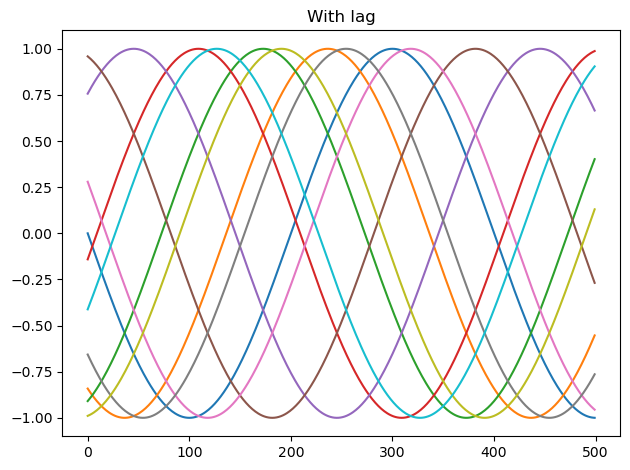

In [26]:
plt.plot(X_1[0:10, 0:500].T);
plt.title("With lag")
plt.tight_layout()

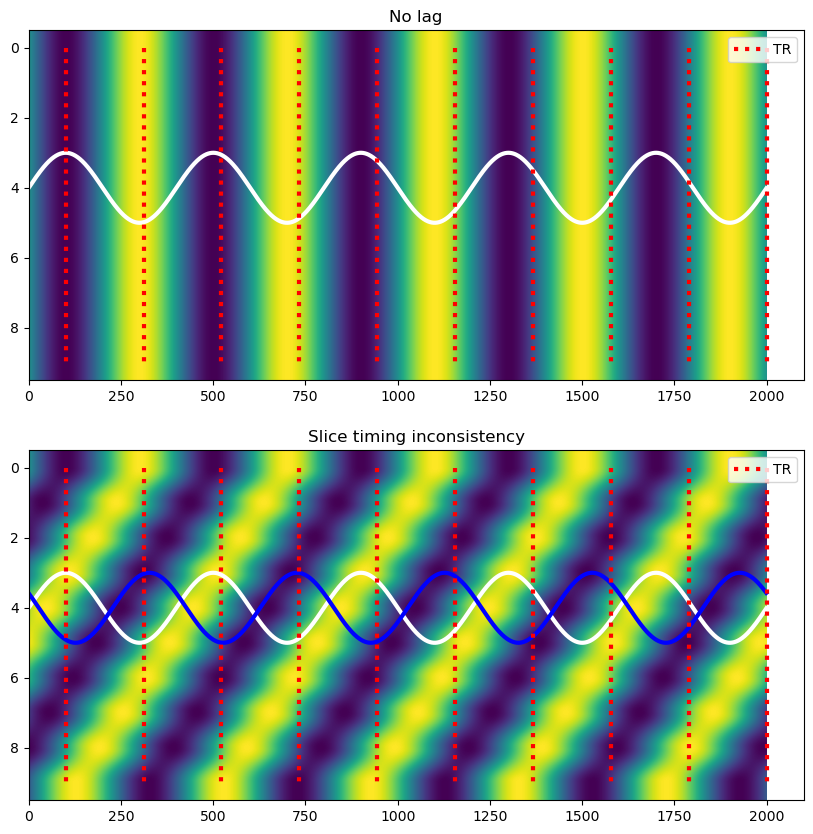

In [55]:
fix, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 10))
ax[0].imshow(X, aspect='auto')
ax[0].plot(X[0, 0:2000] + 4, color='white', lw=3)
ax[1].imshow(X_1, aspect='auto')
ax[1].plot(X[0, 0:2000] + 4, color='white', lw=3)
ax[1].plot(X_1[9, 0:2000] + 4, color='blue', lw=3)
for i in range(2):
    ax[i].vlines(x=np.linspace(100, 2000, 10), ymin=0, ymax=9, color='red', label='TR', linestyle='dotted', lw=3)
    ax[i].legend()

ax[0].set_title('No lag')
ax[1].set_title('Slice timing inconsistency')
fig.tight_layout()

## Interpolate to a point in time (slice timing correction)

Subsequent slices are interpolated to the first sine wave (i.e., no phase shift). Here, we use a linear interpolation and a sinc interpolation.

### Linear interpolation

In [108]:
X_2 = np.copy(X_1)
point = X_1[0, :]
for i in range(1, len(X_2)):
    f = interp1d(point, X_1[i, :])
    X_2[i, :] = f(X_1[i, :])

### Plot

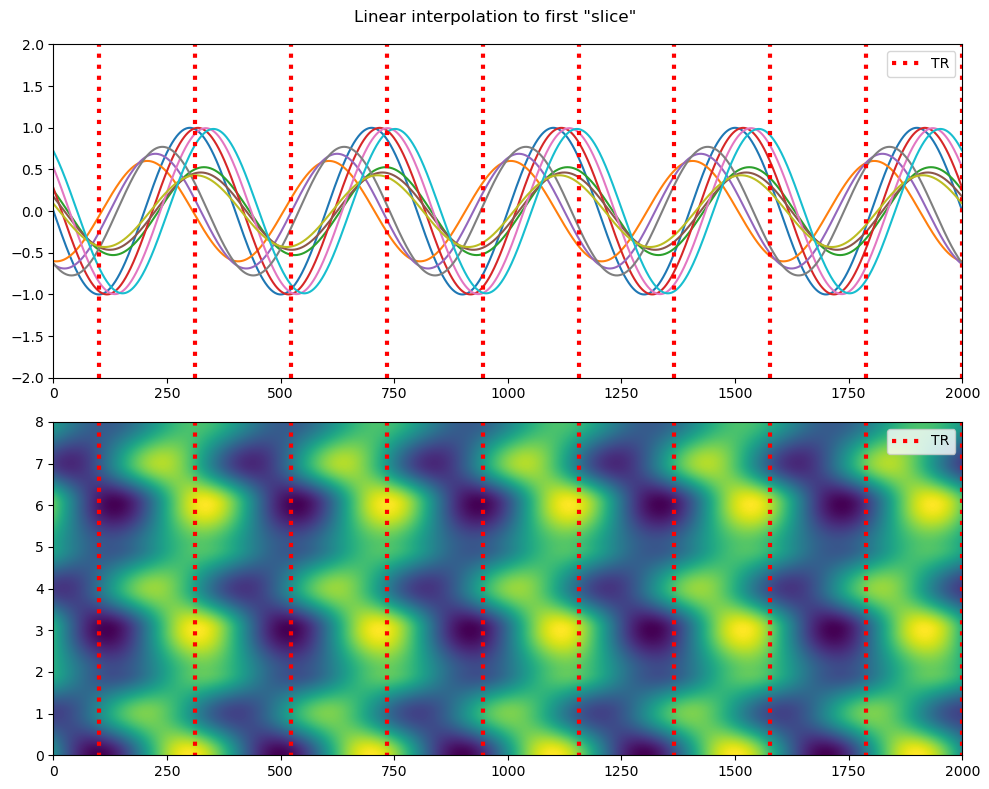

In [53]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 8))
ax[0].plot(X_2.T)
ax[0].set_xlim(0, 2000)
ax[0].set_ylim(-2, 2)
ax[1].imshow(X_2, aspect='auto');
ax[1].set_xlim(0, 2000)
ax[1].set_ylim(0, 8)

for i in range(2):
    ax[i].vlines(x=np.linspace(100, 2000, 10), ymin=-2, ymax=9, color='red', label='TR', linestyle='dotted', lw=3)
    ax[i].legend()

fig.suptitle('Linear interpolation to first "slice"')
fig.tight_layout()

### Sinc

This is the standard method for slice timing correction in canonical fMRI data analysis

### Convolution

Let's convolve the data to a simulated and very not-real HRF, in this case, a gaussian distribution, as denoted by the equation below.

$$

f(\sigma, x, \mu) = \frac{1}{\sigma \sqrt{2 \pi}} \times e^{\frac{-1}{2} \times (\frac{x - \mu}{\sigma})^2}

$$

In [5]:
def make_gauss(x):
    """Genearate a probability density function given an array of numeric values"""

    mu = np.mean(x)
    sigma = np.std(x)
    f = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp( - (x - mu) ** 2 / (2 * sigma**2))
    
    return(f)

In [42]:
x = np.arange(-3, 3, 1/len(X_1))
y = make_gauss()

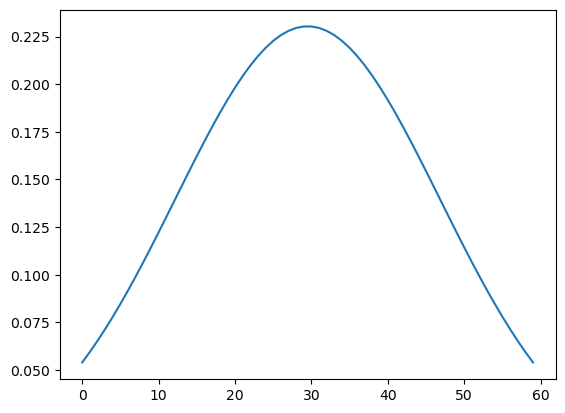

In [43]:
plt.plot(y)

In [109]:
X_conv = np.copy(X_1)
for i in range(0, len(X_conv)):
    y = make_gauss(X_1[i, :])
    X_conv[i, :] = np.convolve(X_1[i, 0:], y, mode='same')

(0.0, 2000.0)

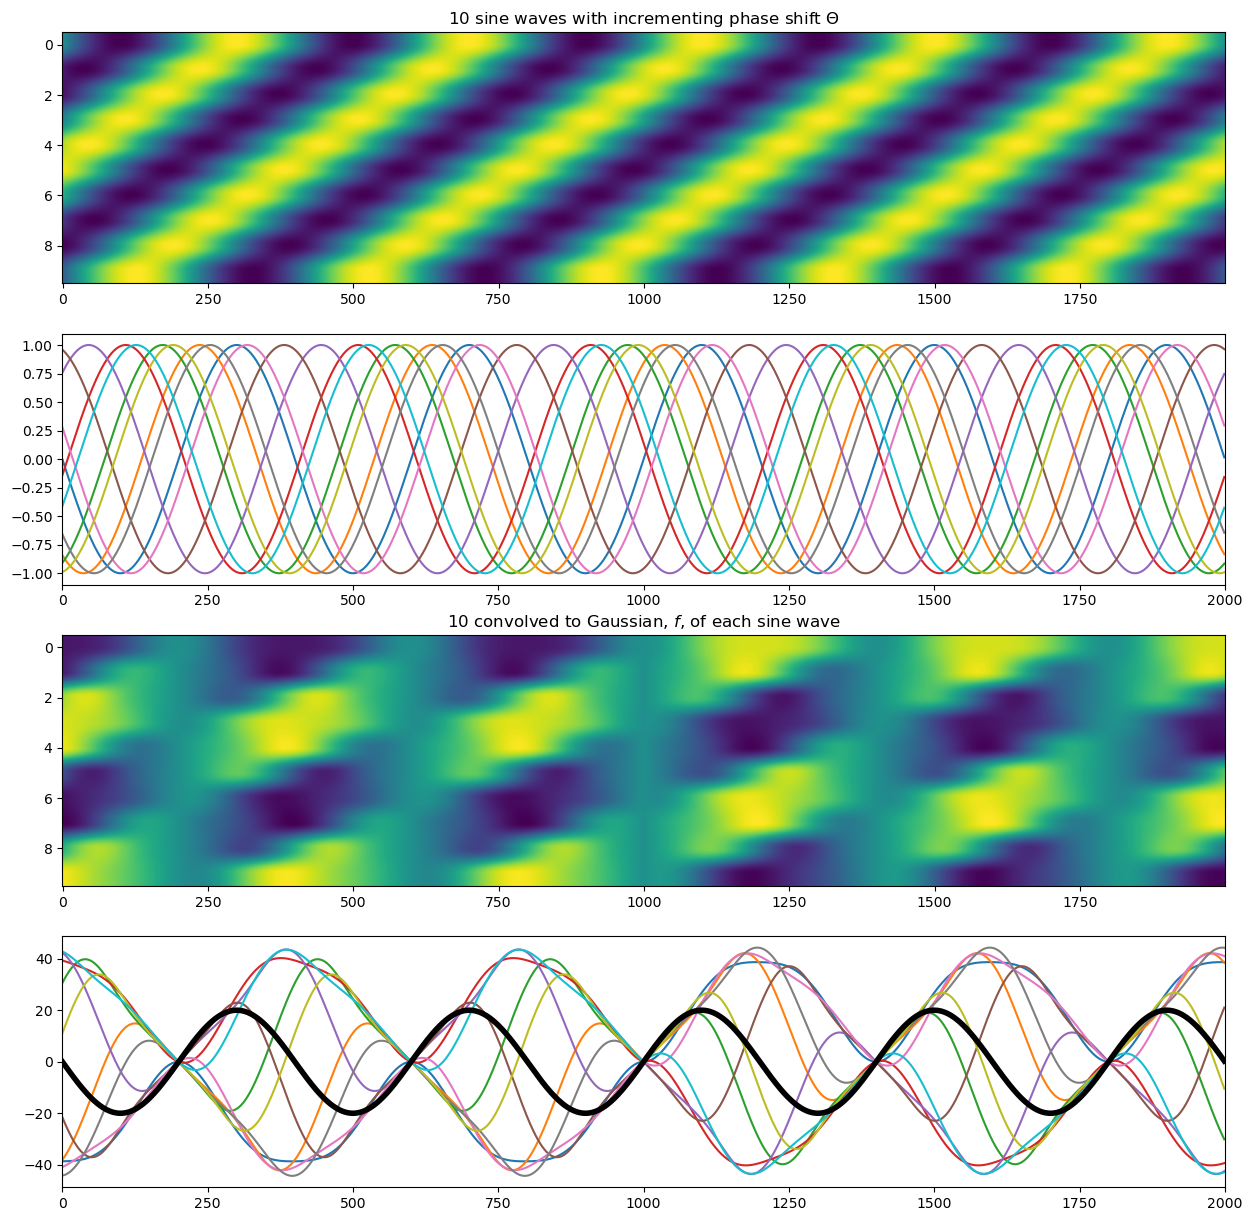

In [110]:
fix, ax = plt.subplots(nrows=4, ncols=1, figsize=(15 , 15))
ax[0].imshow(X_1, aspect='auto')
ax[0].set_title(r"10 sine waves with incrementing phase shift $\Theta$")
ax[1].plot(X_1.T)
ax[1].set_xlim(0, 2000)
ax[2].imshow(X_conv,  aspect='auto')
ax[2].set_title(r"10 convolved to Gaussian, $f$, of each sine wave")
ax[3].plot(X_conv.T)
ax[3].plot(X[0, :].T*20, lw=4, color='k')
ax[3].set_xlim(0, 2000)

